# Exploring Toronto Neighborhoods

In [1]:
import pandas as pd

df = pd.read_csv(r'C:\Users\washb\Documents\toronto_neighborhoods_and_geospatial_data.csv')
df

,Unnamed: 0,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,0,M3A,North York,Parkwoods,43.806686,-79.194353
1,1,M4A,North York,Victoria Village,43.784535,-79.160497
2,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711
3,3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.770992,-79.216917
4,4,M7A,Queen's Park,Ontario Provincial Government,43.773136,-79.239476
...,...,...,...,...,...,...
98,98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.706876,-79.518188
99,99,M4Y,Downtown Toronto,Church and Wellesley,43.696319,-79.532242
100,100,M7Y,East Toronto Business,Enclave of M4L,43.688905,-79.554724
101,101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.739416,-79.588437


In [2]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(df['Borough'].unique()),df.shape[0]))

The dataframe has 15 boroughs and 103 neighborhoods.


In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


# Creating a map with Toronto neighborhoods superimposed on top

In [4]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [5]:


# create map of Toronto using latitude and longitude values
Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto)  
    
Toronto

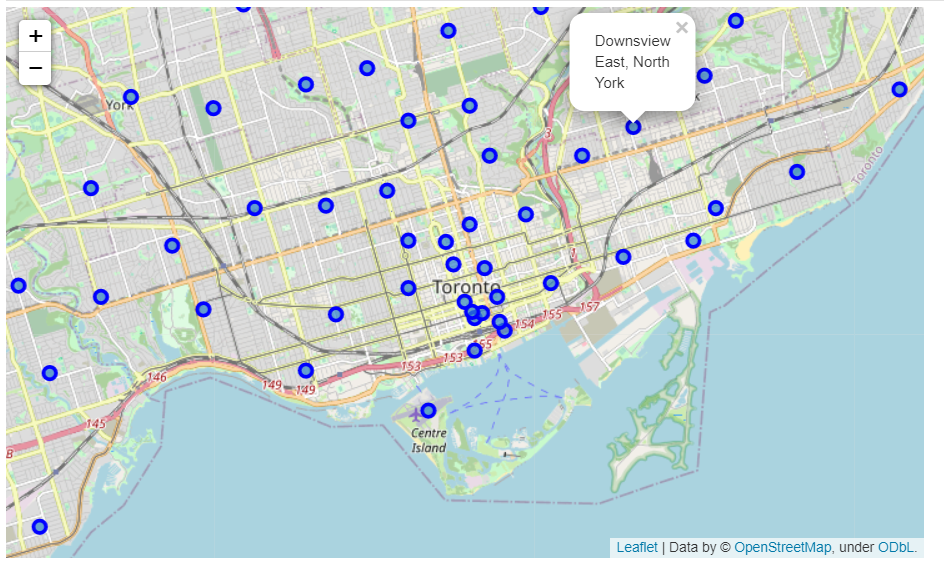

# Segment and Cluster only the neighborhoods in Downtown Toronto

In [19]:
toronto_data = df[df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
toronto_data.head()

,Unnamed: 0,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711
1,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.692657,-79.264848
2,15,M5C,Downtown Toronto,St. James Town,43.799525,-79.318389
3,20,M5E,Downtown Toronto,Berczy Park,43.757490,-79.374714
4,24,M5G,Downtown Toronto,Central Bay Street,43.782736,-79.442259


In [20]:
# create map of Manhattan using latitude and longitude values
map_downtown = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  
    
map_downtown

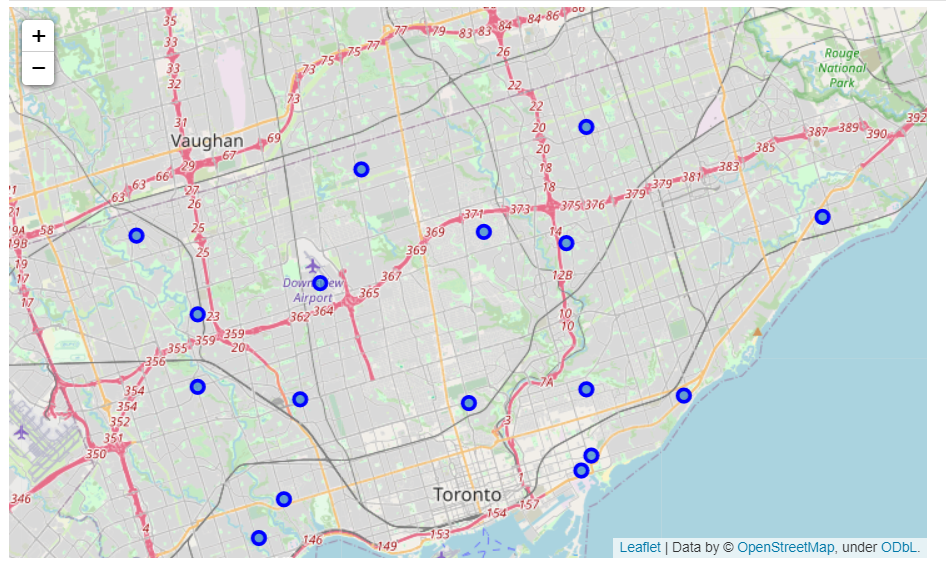

# Explore Toronto Neighborhoods with Foursquare 

In [12]:
CLIENT_ID = 'TUDT3RFTLZZ0Q5DD00GACLY2K4UQRNBWHMVIGVGHZZG0X2OQ' # your Foursquare ID
CLIENT_SECRET = 'MNGUHNMPELGKBAB532TILPFNYVSXCVYTTU4QV33OCTV53VVP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TUDT3RFTLZZ0Q5DD00GACLY2K4UQRNBWHMVIGVGHZZG0X2OQ
CLIENT_SECRET:MNGUHNMPELGKBAB532TILPFNYVSXCVYTTU4QV33OCTV53VVP


In [21]:
toronto_data.loc[0, 'Neighborhood']

'Regent Park, Harbourfront'

In [22]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.7635726, -79.1887115.


Searching for Venues in Toronto Neighborhoods Using Foursquare

In [23]:

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=TUDT3RFTLZZ0Q5DD00GACLY2K4UQRNBWHMVIGVGHZZG0X2OQ&client_secret=MNGUHNMPELGKBAB532TILPFNYVSXCVYTTU4QV33OCTV53VVP&v=20180605&ll=43.7635726,-79.1887115&radius=500&limit=100'

In [24]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6107686b6e05920f7739afdc'},
 'response': {'headerLocation': 'Scarborough Village',
  'headerFullLocation': 'Scarborough Village, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 9,
  'suggestedBounds': {'ne': {'lat': 43.768072604500006,
    'lng': -79.18249216787879},
   'sw': {'lat': 43.7590725955, 'lng': -79.1949308321212}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4beee041e24d20a1cd857314',
       'name': 'RBC Royal Bank',
       'location': {'address': '4374 KINGSTON RD',
        'crossStreet': 'Kingston & Lawrence',
        'lat': 43.76678992471017,
        'lng': -79.19115118872593,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.76678992471017,
          'lng': -79.1911511887

In [25]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [26]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-26-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,RBC Royal Bank,Bank,43.766790,-79.191151
1,G & G Electronics,Electronics Store,43.765309,-79.191537
2,Sail Sushi,Restaurant,43.765951,-79.191275
3,Big Bite Burrito,Mexican Restaurant,43.766299,-79.190720
4,Enterprise Rent-A-Car,Rental Car Location,43.764076,-79.193406


In [27]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

9 venues were returned by Foursquare.


In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:

toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [31]:
print(toronto_venues.shape)
toronto_venues.head()

(134, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
1,"Regent Park, Harbourfront",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
2,"Regent Park, Harbourfront",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant
3,"Regent Park, Harbourfront",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
4,"Regent Park, Harbourfront",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location


In [32]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,7,7,7,7,7,7
Christie,3,3,3,3,3,3
Church and Wellesley,8,8,8,8,8,8
"Commerce Court, Victoria Hotel",2,2,2,2,2,2
"First Canadian Place, Underground city",2,2,2,2,2,2
"Garden District, Ryerson",4,4,4,4,4,4
"Harbourfront East, Union Station, Toronto Islands",5,5,5,5,5,5
"Kensington Market, Chinatown, Grange Park",36,36,36,36,36,36


In [33]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 75 uniques categories.


In [34]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Airport,Auto Workshop,Bank,Bar,Baseball Field,Beer Store,Bookstore,Breakfast Spot,Brewery,Burrito Place,Business Service,Butcher,Café,Chinese Restaurant,Coffee Shop,College Stadium,Comic Shop,Convenience Store,Curling Ice,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Service,French Restaurant,Furniture / Home Store,Garden,Garden Center,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Home Service,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Medical Center,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Rental Car Location,Restaurant,Sandwich Place,School,Skate Park,Skating Rink,Smoothie Shop,Steakhouse,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Trail,Vegetarian / Vegan Restaurant,Yoga Studio
0,"Regent Park, Harbourfront",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
toronto_onehot.shape

(134, 76)

In [36]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Airport,Auto Workshop,Bank,Bar,Baseball Field,Beer Store,Bookstore,Breakfast Spot,Brewery,Burrito Place,Business Service,Butcher,Café,Chinese Restaurant,Coffee Shop,College Stadium,Comic Shop,Convenience Store,Curling Ice,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Service,French Restaurant,Furniture / Home Store,Garden,Garden Center,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Home Service,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Medical Center,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Rental Car Location,Restaurant,Sandwich Place,School,Skate Park,Skating Rink,Smoothie Shop,Steakhouse,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Trail,Vegetarian / Vegan Restaurant,Yoga Studio
0,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.066667,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.066667,0.066667,0.000000,0.066667,0.000000,0.000000,0.000000,0.00,0.066667,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.066667,0.066667,0.00,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.00,0.000000,0.000000,0.000,0.00,0.066667,0.00,0.000000,0.066667,0.000,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.00,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.00,0.000000,0.00,0.142857,0.142857,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.142857,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,Christie,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.00,0.333333,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.125,0.00,0.000000,0.00,0.000000,0.125000,0.125,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00

In [37]:
toronto_grouped.shape

(16, 76)

List of each neighborhood in Toronto with the top 5 most common venues

In [38]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
           venue  freq
0    Pizza Place  0.07
1  Burrito Place  0.07
2     Skate Park  0.07
3     Restaurant  0.07
4           Park  0.07


----Central Bay Street----
           venue  freq
0  Grocery Store  0.14
1    Supermarket  0.14
2       Pharmacy  0.14
3    Coffee Shop  0.14
4        Butcher  0.14


----Christie----
                  venue  freq
0                  Park  0.33
1     Food & Drink Shop  0.33
2  Fast Food Restaurant  0.33
3               Airport  0.00
4          Liquor Store  0.00


----Church and Wellesley----
                       venue  freq
0                Pizza Place  0.12
1  Middle Eastern Restaurant  0.12
2                 Playground  0.12
3               Intersection  0.12
4             Sandwich Place  0.12


----Commerce Court, Victoria Hotel----
                venue  freq
0               Trail   0.5
1         Summer Camp   0.5
2             A

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"CN Tower, King and Spadina, Railway Lands, Har...",Comic Shop,Skate Park,Garden Center,Gym / Fitness Center,Fast Food Restaurant,Farmers Market,Light Rail Station,Park,Pizza Place,Restaurant
1,Central Bay Street,Pharmacy,Grocery Store,Pizza Place,Supermarket,Coffee Shop,Discount Store,Butcher,Electronics Store,Dessert Shop,Diner
2,Christie,Fast Food Restaurant,Park,Food & Drink Shop,Farmers Market,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant
3,Church and Wellesley,Pizza Place,Playground,Coffee Shop,Chinese Restaurant,Discount Store,Sandwich Place,Intersection,Middle Eastern Restaurant,Yoga Studio,Donut Shop
4,"Commerce Court, Victoria Hotel",Trail,Summer Camp,Yoga Studio,Farmers Market,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store


# Clustering Neighborhoods

In [42]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 2, 3, 4, 1, 1, 2, 2])

In [47]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,Unnamed: 0,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711,2.0,2.0,Intersection,Mexican Restaurant,Bank,Medical Center,Donut Shop,Breakfast Spot,Rental Car Location,Restaurant,Electronics Store,Yoga Studio
1,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.692657,-79.264848,1.0,1.0,Skating Rink,General Entertainment,College Stadium,Café,Farmers Market,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant
2,15,M5C,Downtown Toronto,St. James Town,43.799525,-79.318389,2.0,2.0,Coffee Shop,Pharmacy,Sandwich Place,Furniture / Home Store,Bank,Pizza Place,Breakfast Spot,Fast Food Restaurant,Chinese Restaurant,Electronics Store
3,20,M5E,Downtown Toronto,Berczy Park,43.757490,-79.374714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,M5G,Downtown Toronto,Central Bay Street,43.782736,-79.442259,2.0,2.0,Pharmacy,Grocery Store,Pizza Place,Supermarket,Coffee Shop,Discount Store,Butcher,Electronics Store,Dessert Shop,Diner


In [71]:
df = toronto_merged.dropna()
df = df.reset_index(drop = True)
df

,Unnamed: 0,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711,2.0,2.0,Intersection,Mexican Restaurant,Bank,Medical Center,Donut Shop,Breakfast Spot,Rental Car Location,Restaurant,Electronics Store,Yoga Studio
1,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.692657,-79.264848,1.0,1.0,Skating Rink,General Entertainment,College Stadium,Café,Farmers Market,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant
2,15,M5C,Downtown Toronto,St. James Town,43.799525,-79.318389,2.0,2.0,Coffee Shop,Pharmacy,Sandwich Place,Furniture / Home Store,Bank,Pizza Place,Breakfast Spot,Fast Food Restaurant,Chinese Restaurant,Electronics Store
3,24,M5G,Downtown Toronto,Central Bay Street,43.782736,-79.442259,2.0,2.0,Pharmacy,Grocery Store,Pizza Place,Supermarket,Coffee Shop,Discount Store,Butcher,Electronics Store,Dessert Shop,Diner
4,25,M6G,Downtown Toronto,Christie,43.753259,-79.329656,1.0,1.0,Fast Food Restaurant,Park,Food & Drink Shop,Farmers Market,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant
5,30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.737473,-79.464763,1.0,1.0,Airport,Business Service,Park,Furniture / Home Store,French Restaurant,Food Service,Food & Drink Shop,Fish Market,Fish & Chips Shop,Deli / Bodega
6,36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.695344,-79.318389,1.0,1.0,Skating Rink,Beer Store,Intersection,Park,Curling Ice,Food & Drink Shop,Food Service,Fish Market,Fish & Chips Shop,Fast Food Restaurant
7,42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.668999,-79.315572,2.0,2.0,Sandwich Place,Park,Pizza Place,Brewery,Italian Restaurant,Ice Cream Shop,Pet Store,Pub,Gym,Restaurant
8,48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.689574,-79.383160,3.0,3.0,Trail,Summer Camp,Yoga Studio,Farmers Market,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store
9,80,M5S,Downtown Toronto,"University of Toronto, Harbord",43.691116,-79.476013,2.0,2.0,Convenience Store,Coffee Shop,Discount Store,Sandwich Place,Curling Ice,Dessert Shop,Diner,Donut Shop,Electronics Store,Falafel Restaurant


In [72]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

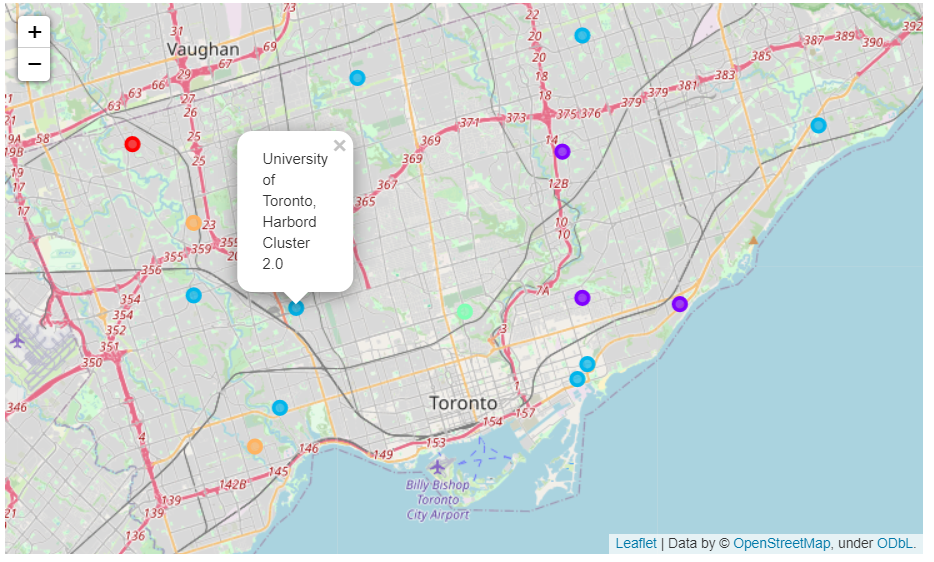

Cluster 1

In [74]:
df.loc[df['Cluster Labels'] == 0, df.columns[[1] + list(range(5, df.shape[1]))]]

,PostalCode,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,M4X,-79.565963,0.0,0.0,Pizza Place,Gym,Home Service,Yoga Studio,Farmers Market,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store


Cluster 2

In [76]:
df.loc[df['Cluster Labels'] == 1, df.columns[[1] + list(range(5, df.shape[1]))]]

,PostalCode,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M5B,-79.264848,1.0,1.0,Skating Rink,General Entertainment,College Stadium,Café,Farmers Market,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant
4,M6G,-79.329656,1.0,1.0,Fast Food Restaurant,Park,Food & Drink Shop,Farmers Market,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant
5,M5H,-79.464763,1.0,1.0,Airport,Business Service,Park,Furniture / Home Store,French Restaurant,Food Service,Food & Drink Shop,Fish Market,Fish & Chips Shop,Deli / Bodega
6,M5J,-79.318389,1.0,1.0,Skating Rink,Beer Store,Intersection,Park,Curling Ice,Food & Drink Shop,Food Service,Fish Market,Fish & Chips Shop,Fast Food Restaurant


Cluster 3

In [77]:
df.loc[df['Cluster Labels'] == 2, df.columns[[1] + list(range(5, df.shape[1]))]]

,PostalCode,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,-79.188711,2.0,2.0,Intersection,Mexican Restaurant,Bank,Medical Center,Donut Shop,Breakfast Spot,Rental Car Location,Restaurant,Electronics Store,Yoga Studio
2,M5C,-79.318389,2.0,2.0,Coffee Shop,Pharmacy,Sandwich Place,Furniture / Home Store,Bank,Pizza Place,Breakfast Spot,Fast Food Restaurant,Chinese Restaurant,Electronics Store
3,M5G,-79.442259,2.0,2.0,Pharmacy,Grocery Store,Pizza Place,Supermarket,Coffee Shop,Discount Store,Butcher,Electronics Store,Dessert Shop,Diner
7,M5K,-79.315572,2.0,2.0,Sandwich Place,Park,Pizza Place,Brewery,Italian Restaurant,Ice Cream Shop,Pet Store,Pub,Gym,Restaurant
9,M5S,-79.476013,2.0,2.0,Convenience Store,Coffee Shop,Discount Store,Sandwich Place,Curling Ice,Dessert Shop,Diner,Donut Shop,Electronics Store,Falafel Restaurant
10,M5T,-79.484450,2.0,2.0,Café,Coffee Shop,Italian Restaurant,Sushi Restaurant,Pizza Place,Pub,Fish Market,Indie Movie Theater,Ice Cream Shop,Gym
11,M5V,-79.321558,2.0,2.0,Comic Shop,Skate Park,Garden Center,Gym / Fitness Center,Fast Food Restaurant,Farmers Market,Light Rail Station,Park,Pizza Place,Restaurant
15,M4Y,-79.532242,2.0,2.0,Pizza Place,Playground,Coffee Shop,Chinese Restaurant,Discount Store,Sandwich Place,Intersection,Middle Eastern Restaurant,Yoga Studio,Donut Shop


Cluster 4

In [78]:
df.loc[df['Cluster Labels'] == 3, df.columns[[1] + list(range(5, df.shape[1]))]]

,PostalCode,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,M5L,-79.38316,3.0,3.0,Trail,Summer Camp,Yoga Studio,Farmers Market,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store


Cluster 5

In [79]:
df.loc[df['Cluster Labels'] == 4, df.columns[[1] + list(range(5, df.shape[1]))]]

,PostalCode,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,M4W,-79.498509,4.0,4.0,Deli / Bodega,Baseball Field,Fast Food Restaurant,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market
14,M5X,-79.532242,4.0,4.0,Baseball Field,Food Service,Yoga Studio,Farmers Market,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant
